In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import *
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import cross_val_score 
from sklearn.decomposition import PCA

# Part 1 ‐ Exploratory data analysis

In [2]:
logins = pd.read_json("logins.json")
logins.shape

(93142, 1)

In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [4]:
logins.index = logins['login_time']
logins['count'] = 1
logins.head()

,login_time,count
login_time,,
1970-01-01 20:13:18,1970-01-01 20:13:18,1
1970-01-01 20:16:10,1970-01-01 20:16:10,1
1970-01-01 20:16:37,1970-01-01 20:16:37,1
1970-01-01 20:16:36,1970-01-01 20:16:36,1
1970-01-01 20:26:21,1970-01-01 20:26:21,1


In [5]:
rs_df = logins.resample('15T').sum().reset_index()
rs_df['hour'] = pd.DatetimeIndex(rs_df['login_time']).hour
rs_df.head()

,login_time,count,hour
0,1970-01-01 20:00:00,2,20
1,1970-01-01 20:15:00,6,20
2,1970-01-01 20:30:00,9,20
3,1970-01-01 20:45:00,7,20
4,1970-01-01 21:00:00,1,21


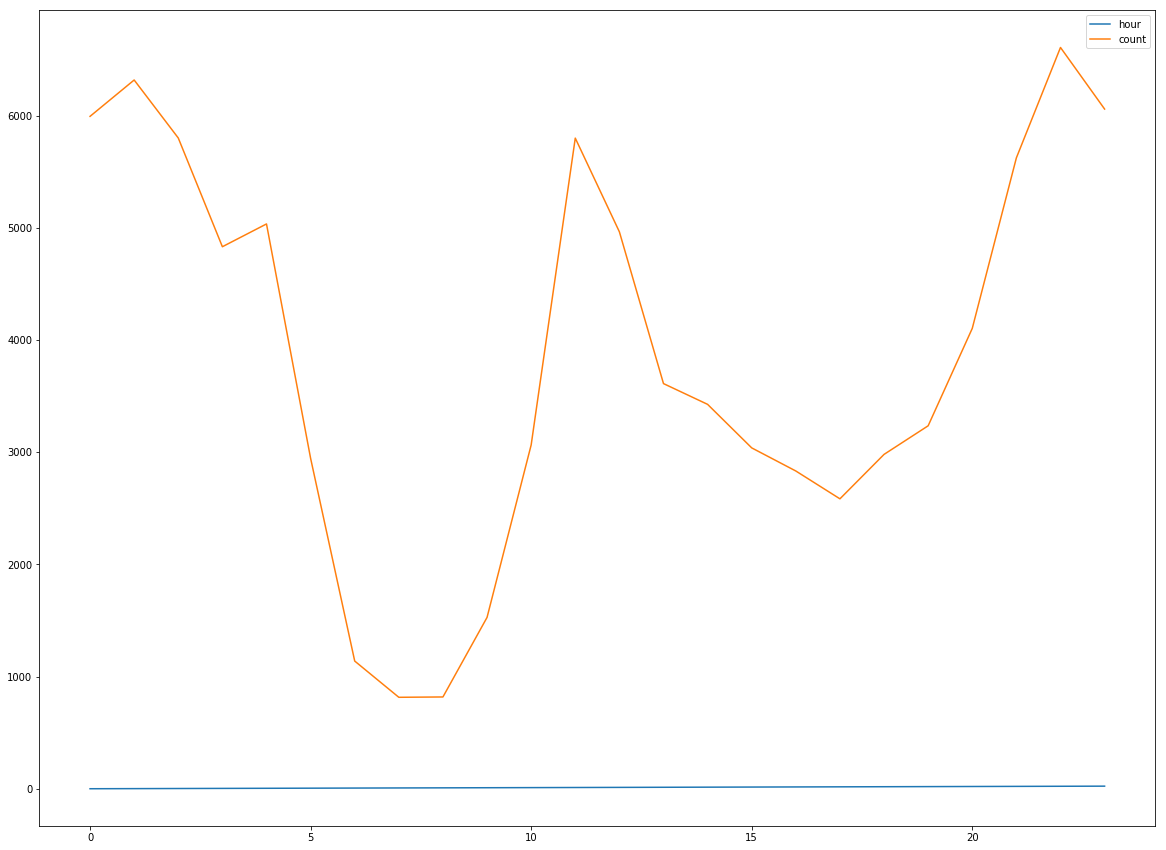

In [35]:
rs_df.groupby(['hour'])['count'].sum().reset_index().plot()
_ = rcParams['figure.figsize'] = [20, 15]
plt.show()

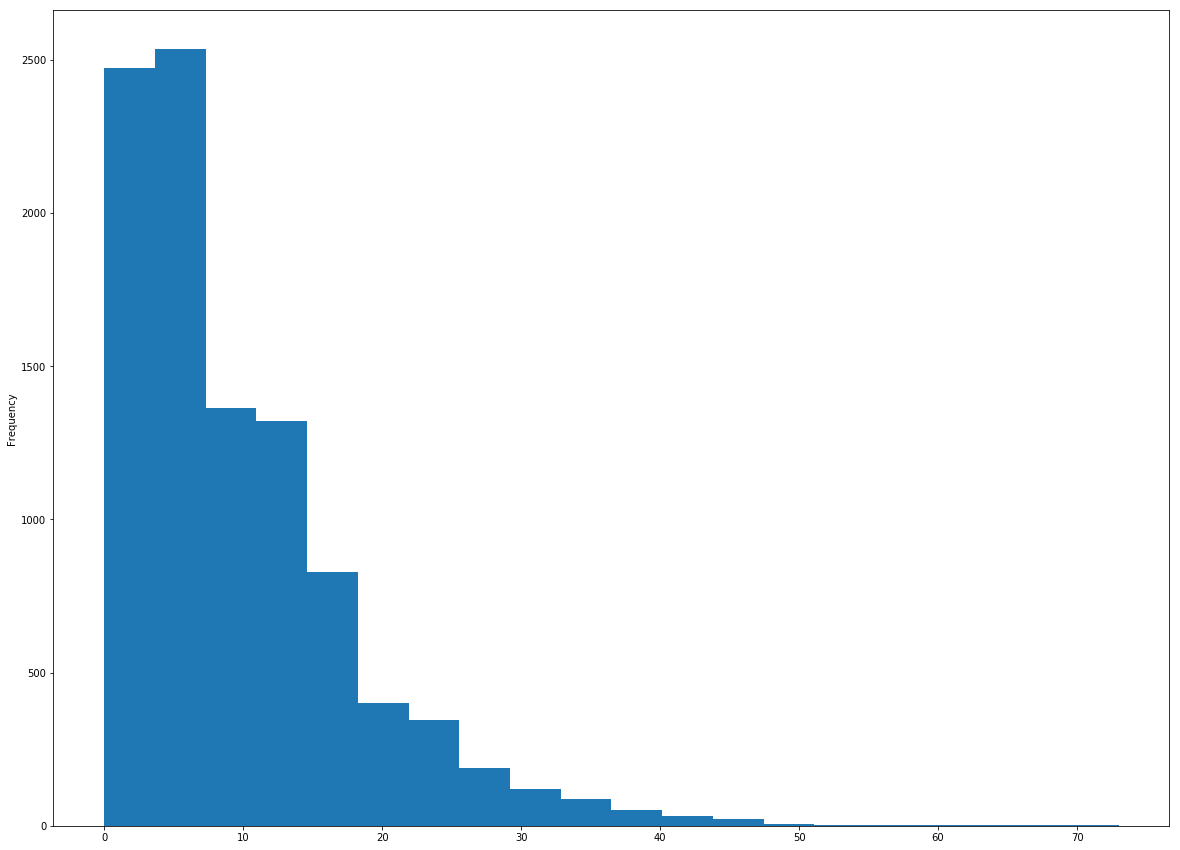

In [7]:
login_15 = logins.resample('15T').sum().reset_index()
login_15['count'].plot(kind='hist',bins=20)
_ = rcParams['figure.figsize'] = [20, 15]
plt.show()

In [8]:
def ecdf(data):
    n = len(data)*1.0
    x = np.sort(data)
    y= np.arange(1,n+1)/n
    return x,y

def verifyECDF():
    x,y = ecdf(login_15['count'])
    _ = plt.plot(x,y,marker='.',linestyle='none')
    _ = plt.margins(0.02)
    _ = plt.xlabel('count')
    _ = plt.ylabel('ECDF')
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    _ = plt.legend(('count'), loc='lower right')
    plt.show()

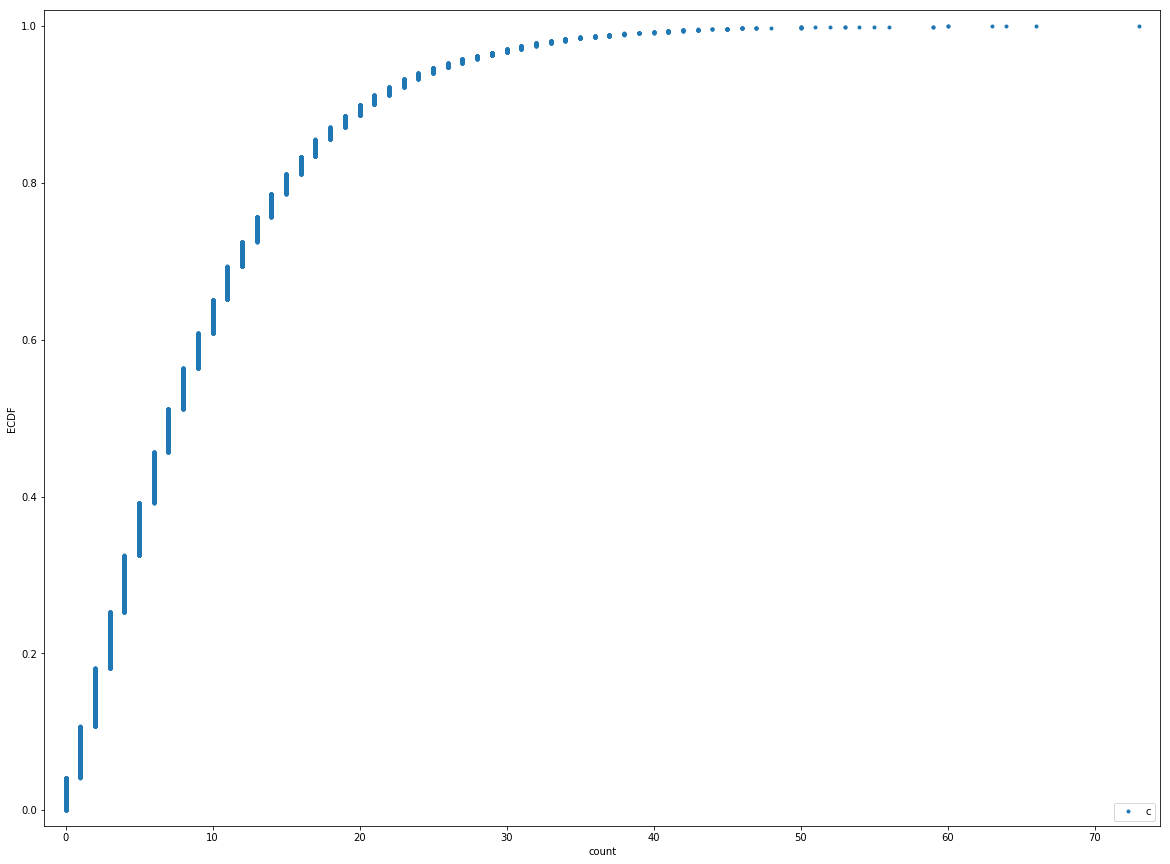

In [9]:
verifyECDF()

## It can be noticed from above charts that 85 percent of time the logins per 15 minutes is less than 25 and 15 percent of times the # of logins will be higher than 25/15 mins
## The peak and valleys in demand seem to be based on users logging in from across the globe (mainly America, APAC, EMEA)

# Part 2 ‐ Experiment and metrics design


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? <br>
> **Answer:** Reimbursing the toll for driver partners serving between 2 cities will lead to increase in driver pool (availability), i.e there would be more drivers available to answer a ride request for neighboring city and in general customers would wait less time for their ride to arrive.
*Hence, the `metric` or `KPI` for success of this experiment, that I choose is customer `wait_time`(new field to be introduced) and weekday trip percent `weekday_pct`, which should be higher with this experiment, resulting in increase in trips percentage*

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:<br>
> **Experiment :** Selected Driver Partners based in both cities will be offered toll reimbursement, if they choose to accept ride to other city.


> - How you will implement the experiment <br>
**Answer:** The data is collected for this experiment, where driver partners chose to drive to other city when offered toll reimbursement and who declined to ride across the city. 
    Descriptive and prescriptive statistical methods are applied to infer meaningful conclusions.
    Calculate average `wait_time` and `weekday_pct` of customers who took the ride across city.


> - What statistical test(s) you will conduct to verify the significance of the 
observation <br>
**Answer:** I will apply statistical significance test with 
    Null Hypothesis: The `wait_time` of customers travelling to other city has reduced and `weekday_pct` increases<br>
    Alternative Hypothesis: The `wait_time` and `weekday_pct` of customers has not changed.
    

> - How you would interpret the results and provide recommendations to the city 
operations team along with any caveats. <br>
**Answer:** The `p-value` for the test is calculated and is compared against `alpha` (threshold - 0.05)<br>
If the `p-value` is less than alpha the alternative hypothesis is rejected.

***
<h4>Recommendations: </h4> This experiment is crucial to understand pulse of the driver partners and to serve more customers and improve business for Ultimate Inc.<br>
**_There difference in KPI's is statistically significant, hence It would be in the best interest of Customer, Company and Drivers to offer toll reimbursement._**

***

# Part 3 - Predictive modeling

In [10]:
dat = json.load((open('ultimate_data_challenge.json')))

In [11]:
dat = json_normalize(dat)
dat.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [12]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## It can be noticed from above that there are null values for `phone`, `avg_rating_by_driver`, `avg_rating_of_driver`

In [13]:
values = {'phone': '','avg_rating_of_driver':round(np.mean(dat['avg_rating_of_driver']),2),'avg_rating_by_driver':round(np.mean(dat['avg_rating_by_driver']),2)}
dat.fillna(value=values,inplace=True)

In [14]:
dat.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## Cleaned the data to fill all NaN values with appropriate values

In [15]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


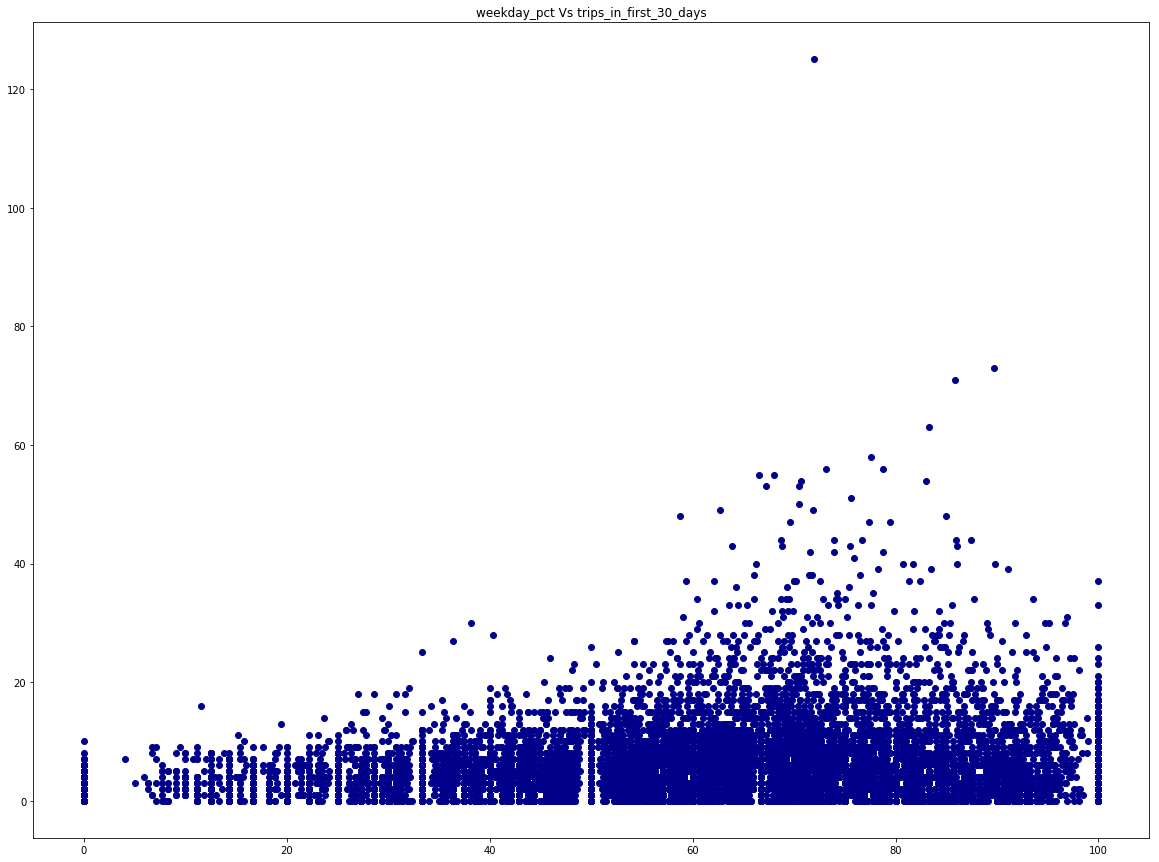

In [16]:
plt.scatter(x=dat['weekday_pct'],y=dat['trips_in_first_30_days'], c='DarkBlue')
plt.title("weekday_pct Vs trips_in_first_30_days")
plt.show()

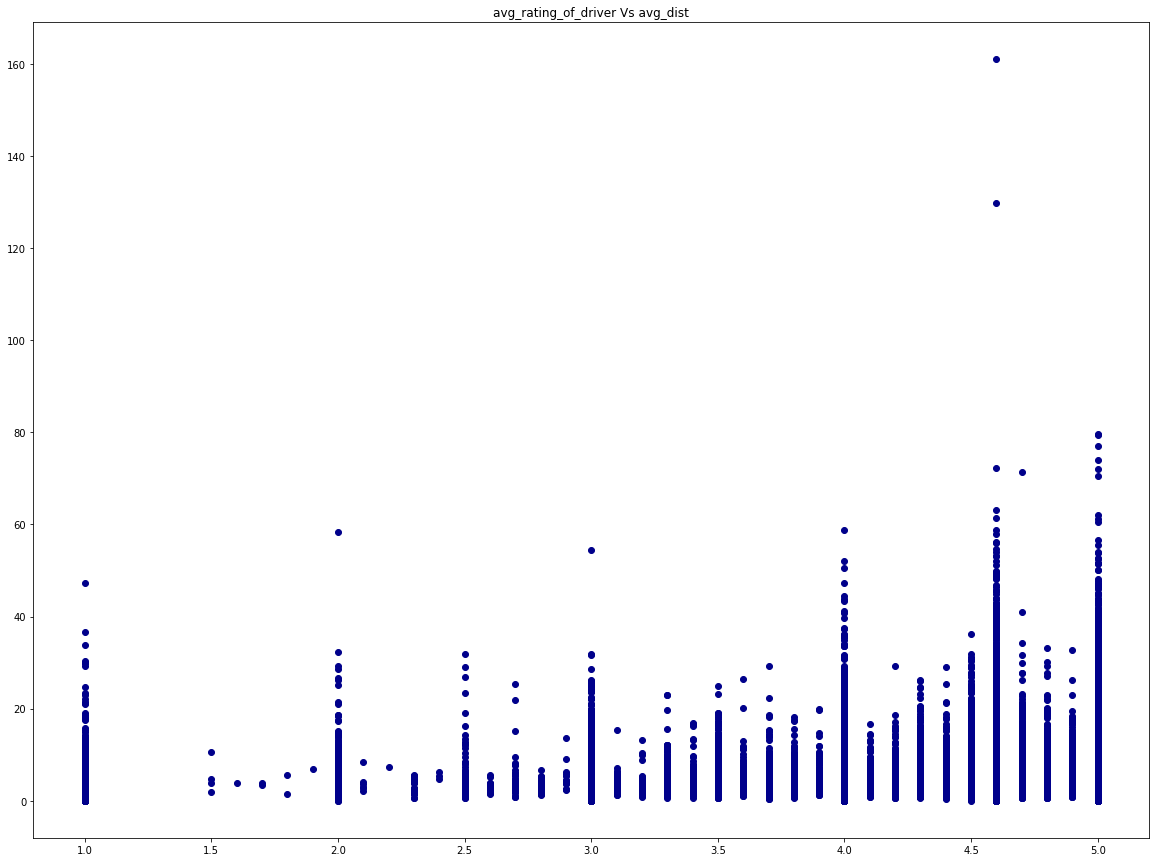

In [17]:
plt.scatter(x=dat['avg_rating_of_driver'],y=dat['avg_dist'], c='DarkBlue')
plt.title("avg_rating_of_driver Vs avg_dist")
plt.show()

In [18]:
#dat.loc[dat['trips_in_first_30_days']>0,'active']=1
#dat['active'].fillna(0,inplace=True)
#np.divide(np.sum(dat['active']),len(dat['active']))
#sns.heatmap(dat.corr(), square=True, cmap='RdYlGn')
#dat['prior_30_days'] = 1
#dat['prior_30_days'] = pd.to_datetime(dat['last_trip_date']) - pd.to_timedelta(30,unit='d')

In [19]:
dat.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Assuming the data extract date is the same as most recent `last_trip_date`

In [20]:
pd.to_datetime(dat['last_trip_date'].max())

Timestamp('2014-07-01 00:00:00')

## Calculate difference between the Extract Date and Last Trip date

In [21]:
diff = pd.to_timedelta(pd.to_datetime(dat['last_trip_date'].max())-pd.to_datetime(dat['last_trip_date']),unit='d')
dat['time_diff'] = diff.astype('timedelta64[D]')

In [22]:
dat.loc[dat['time_diff']<30,'active']=1
dat['active'].fillna(0,inplace=True)

## If the Last Trip is with in 30 days of data extract date, the customer is considered `Active`

In [23]:
del dat['time_diff']

In [24]:
dat.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0


In [25]:
np.mean(dat['active'])

0.3662

## 36 percent of customers signedup in Janruary of the Year are found to be active when this data was extracted by Ultimate Inc

In [26]:
dat['lasttrip_month'] = pd.DatetimeIndex(dat['last_trip_date']).month

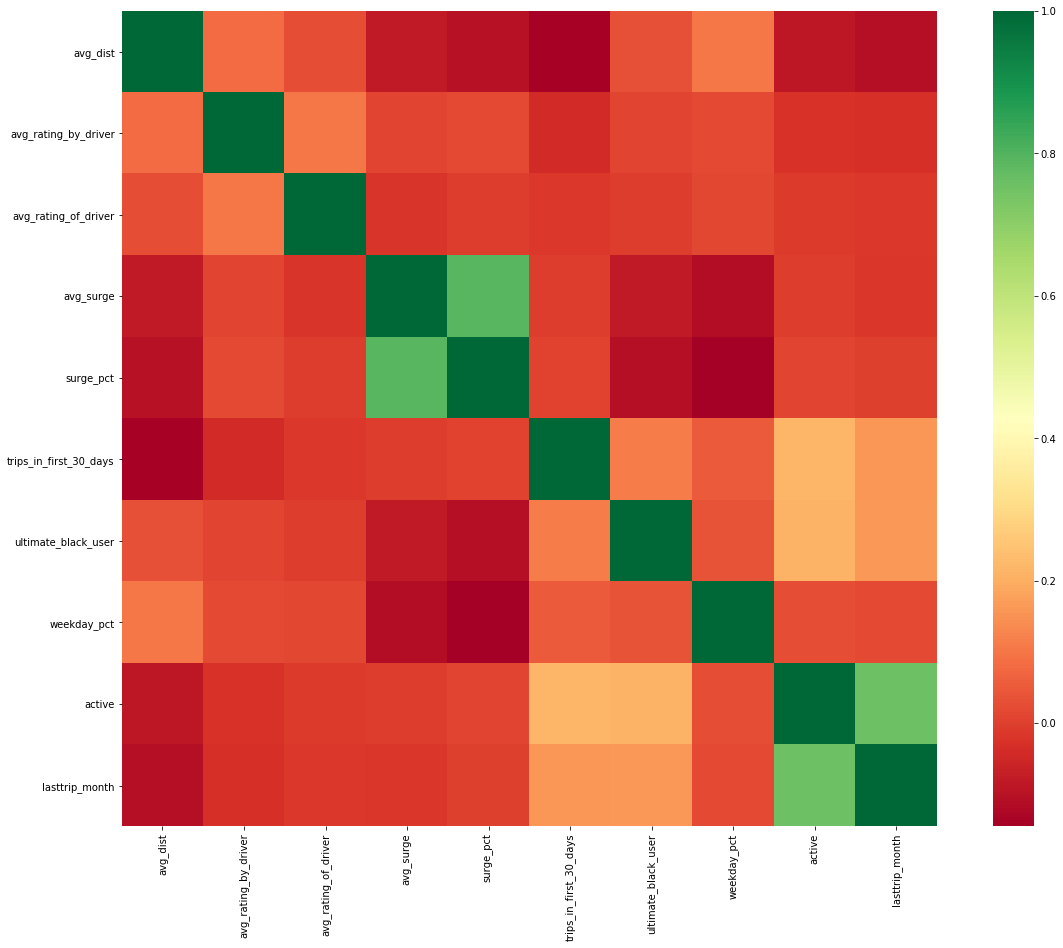

In [27]:
sns.heatmap(dat.drop(['signup_date','last_trip_date'],axis=1).corr(), square=True, cmap='RdYlGn')

In [28]:
#dat['6th_month_system']=pd.to_datetime(dat['signup_date']) + pd.DateOffset(months=5)
#dat['6th_month'] = pd.DatetimeIndex(dat['6th_month_system']).month

In [29]:
dat.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,lasttrip_month
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0,6
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0,5
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0,6
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0,3


## This is a Classification problem and as the labels are already know we will choose Supervised Learning Model

In [30]:
def logisticRegression(df):
    df = df.sample(frac=1)
    X = df.drop(['active','signup_date','last_trip_date','lasttrip_month','avg_dist'],axis=1).values
    y = df['active'].values#.reshape(-1,1)
 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
    # Create the classifier: logreg
    logreg = LogisticRegression()    
    # Fit the classifier to the training data
    logreg.fit(X_train,y_train)    
    # Predict the labels of the test set: y_pred
    y_pred = logreg.predict(X_test)    
    # Compute and print the confusion matrix and classification report
    """
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    """
    print(logreg.coef_)
    y_pred_prob = logreg.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

    # Compute cross-validated AUC scores: cv_auc
    cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
    
    # Print list of AUC scores
    print("AUC scores computed using 5-fold cross-validation: {}".format(np.mean(cv_auc)))
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    return logreg

In [31]:
#month_6_df = dat[dat['lasttrip_month']==6]

[[-1.54372011e-01 -4.12748167e-02 -1.59015337e-01 -8.50870313e-01
   1.04712564e+00  5.20437701e-03  1.28909883e-01  8.78884718e-01
   5.72684144e-04]]
AUC: 0.757299663591
AUC scores computed using 5-fold cross-validation: 0.758469877925


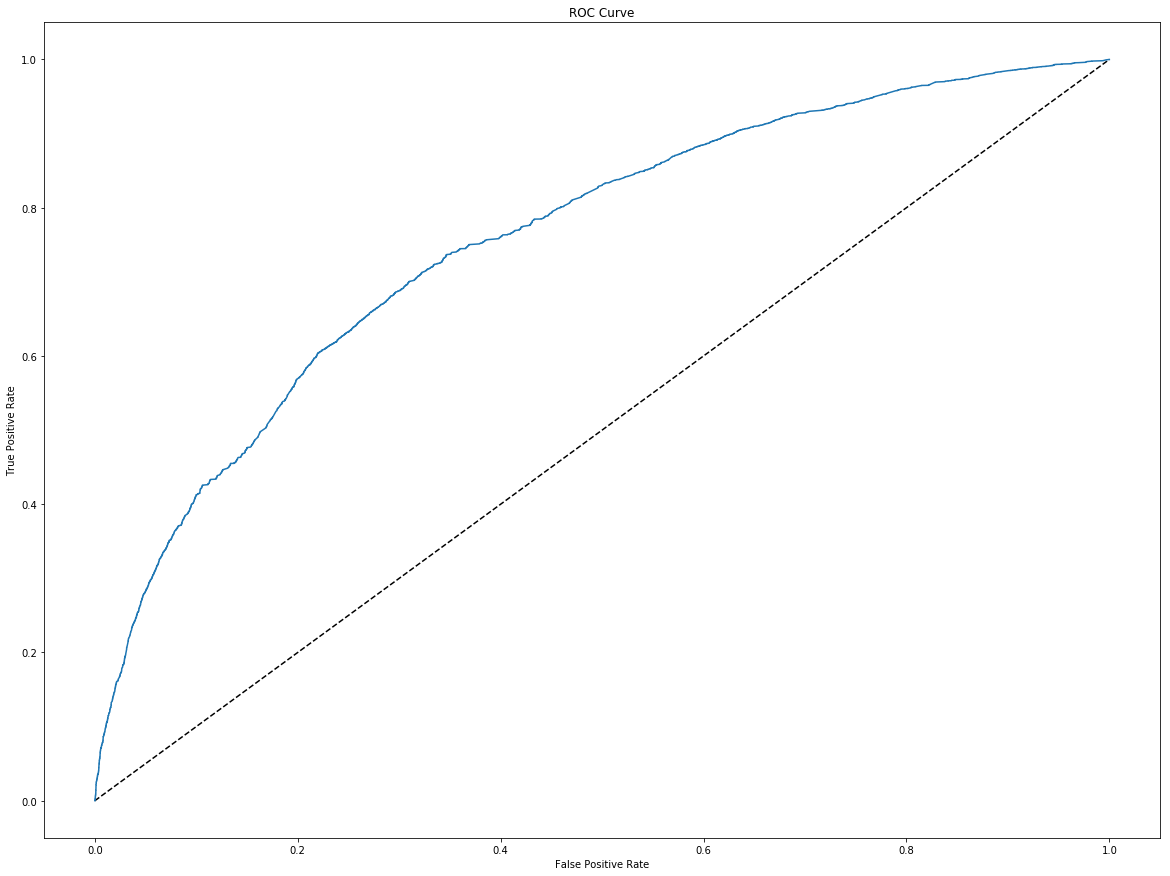

In [32]:
copy = dat.copy()
replace_city = {"city":     {"King's Landing": 0, "Winterfell": 1, "Astapor":2}}
replace_phone = {"phone":     {"Android": 0, "iPhone": 1,"":2}}
copy.replace(replace_city,inplace=True)
copy.replace(replace_phone,inplace=True)
logreg = logisticRegression(copy)

## Alternatives , Other machine learning models which are compute intensive like Random Forest and others could be used, but as this dataset is not a very complex dataset and Logistic regression is found to be able to efficiently predict the results

In [33]:
df = dat.drop(['active','signup_date','last_trip_date','lasttrip_month','avg_dist'],axis=1)
df.head()

,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2
1,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0
2,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0
3,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0
4,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4


In [34]:
print(logreg.coef_)

[[-1.54372011e-01 -4.12748167e-02 -1.59015337e-01 -8.50870313e-01
   1.04712564e+00  5.20437701e-03  1.28909883e-01  8.78884718e-01
   5.72684144e-04]]


## Based on above features importances, we see below three features are highly correlated to results 
> phone <br>
> trips_in_first_30_days<br>
> ultimate_black_user




## Conclusions: 
**Early Adoption is a key for Ultimate Inc to retain users in log run**<br>
**Connecting to Customers through phone is crucial, so Ultimate Inc can have user experience to the best**<br>